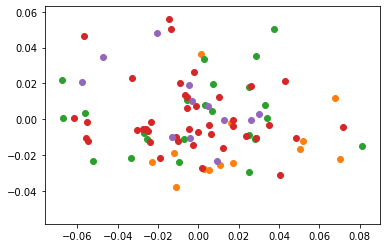

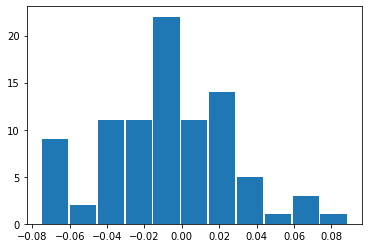

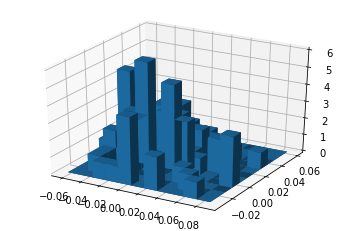

In [6]:
import csv
import numpy as np
import numpy.matlib
import pandas as pd
import scipy.sparse.linalg as ll
import matplotlib.pyplot as plt
import seaborn as sea
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing

# load dataset
path = 'n90pol.csv'

data = pd.read_csv(path,header=0).to_numpy()
y = data[:,2]
# data.shape is (90,2)
data = data[:,:2]


plt.scatter(data[np.where(y == 1),0],data[np.where(y == 1),1])
plt.scatter(data[np.where(y == 2),0],data[np.where(y == 2),1])
plt.scatter(data[np.where(y == 3),0],data[np.where(y == 3),1])
plt.scatter(data[np.where(y == 4),0],data[np.where(y == 4),1])
plt.scatter(data[np.where(y == 5),0],data[np.where(y == 5),1])
plt.show()

# histogram for first dimension of pdata
# find the range of the data
min_data = min(data[:,0])
max_data = max(data[:,0])
nbin = 10     # you can change the number of bins in each dimension
sbin = (max_data - min_data) / nbin
#create the bins

# arange([start,] stop[, step,], dtype=None)
# Return evenly spaced values within a given interval.
boundary = np.arange(min_data-0.0001, max_data,sbin)

# just loop over the data points, and count how many of data points are in each bin
myhist = np.zeros(nbin+1)

m = data.shape[0]

for i in range (m):
    whichbin = np.max(np.where(data[i,0] > boundary))
    #np.max returns index from 0 to 10.
    myhist[whichbin] = myhist[whichbin] + 1

#myhist = np.divide(np.dot(myhist, nbin), data.shape[0])

# bar chart
plt.figure()
# sbin = 0.01488, then width is chosen as 0.014
plt.bar(boundary, myhist, align='center', width = 0.014)

plt.show()

# for 2 dimensional data
min_data = data.min(0)
max_data = data.max(0)

# To get a suitable bin number, calculate Silverman's rule of thumb first.
h1= 1.06*np.sqrt(np.var(data[:,:1]))*(m)**(-0.2)
# print(h1) #Output: 0.013973984566878187
nbin1 = (max_data[0]-min_data[0])/h1
#print(nbin1) #--> 10.648358690240215
h2= 1.06*np.sqrt(np.var(data[:,1:2]))*(m)**(-0.2)
#print(h2) #--> 0.008758179725254514
nbin2 = (max_data[1]-min_data[1])/h2
#print(nbin2) #--> 10.68715223211293

# According to the above calculation, amygdala gives a bin number of 10.6, and acc gives a bin number of 10.7. 
# So nbin is chosen as 11. I also tried nbin as 8 and 14. According to the output, 14 is also OK, 8 is too small.
nbin = 11        
fig = plt.figure()

# *pos* is a three digit integer, where the first digit is the
# number of rows, the second the number of columns, and the third the index of the subplot
ax = fig.add_subplot(111, projection='3d')
# return hist = ndarray, shape(nx, ny)

hist, xedges, yedges = np.histogram2d(data[:,0], data[:,1], bins=nbin)
# I do not understand the reason of the way of obtaining xpos (xedges[:-1]+xedges[1:] and then /2)
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])
xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
# zpos is an array of zeros
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()
# dx, dy, dz is width, depth, and height of the bars

ax.bar3d(xpos, ypos, zpos, dx, dy, dz )


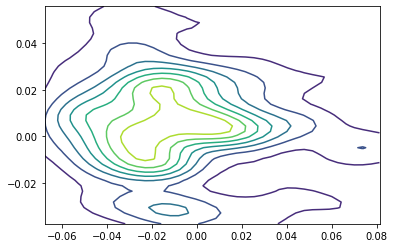

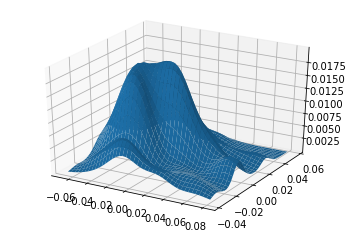

In [7]:
#kernel density estimator
# create an evaluation grid
gridno = 40
# max_data is [0.0812 0.0559]
# min_data is [-0.0676 -0.0377]

inc1 = (max_data[0]-min_data[0])/gridno
inc2 = (max_data[1]-min_data[1])/gridno

# Make sure that np.arange(min_data[0], max_data[0]+inc1/2,inc1) returns an array of shape (41,)
gridx, gridy = np.meshgrid( np.arange(min_data[0], max_data[0]+inc1/2,inc1), np.arange(min_data[1], max_data[1]+inc2/2,inc2) )
# print(gridx.shape) #Output: (41,41) density

gridall = [gridx.flatten(order = 'F'), gridy.flatten(order = 'F')]
gridall = (np.asarray(gridall)).T
#print(gridall.shape) #--> (1681, 2), the 1681 pairs of (x,y)

def gaussian_kernel(x):
    return (1/np.sqrt(2*np.pi))*(np.e**(-(sum(x**2))/2))

def kde(xy, x_all, h):
    px = 0
    for x_i in x_all:
        px += 1/h*gaussian_kernel((x_i-xy)/h)
    return px/len(x_all)

# According to Silverman's rule of thumb, amygdala gives a bandwidth of 0.013973984566878187 (h1)
# and acc gives a bandwidth of 0.008758179725254514 (h2)
# h = h1, h2 or 0.004 are tested.
# Using h1 gives a too smooth contour.
# h2 shows a better resolution and an accceptable noise. 
# 0.004 gives too many noise
h = h2

px_all = []
for xy in gridall:
    px = kde(xy, data[:,:2], h)
    px_all.append(px)

mkde = np.reshape(px_all, gridx.shape)
#print(mkde.shape) #--> (41,41)

# Scaling factor to make sum(mkde) closer to 1
scaling_factor = 1/inc1
mkde = mkde/scaling_factor
#print(np.sum(mkde)) #-->8.896659316618887

plt.contour(gridx, gridy, mkde)
plt.show()

fig = plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.plot_surface(gridx, gridy, mkde)
plt.show()



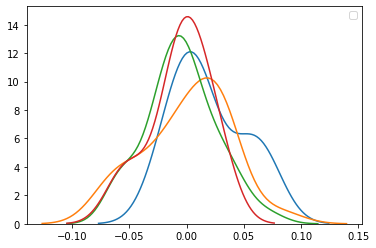

In [8]:
for i in range(2,6):
    amygdala_data = data[np.where(y == i),0].reshape(-1)
    #Default kernel='gau'
    sea.kdeplot(amygdala_data)
    
plt.legend(labels=['Orientation 2', 'Orientation 3', 'Orientation 4', "Orientation 5"])
plt.show()

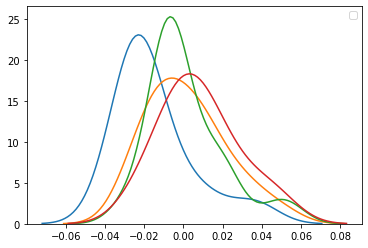

In [9]:
for i in range(2,6):
    amygdala_data = data[np.where(y == i),1].reshape(-1)
    #Default kernel='gau'
    sea.kdeplot(amygdala_data)
    
plt.legend(labels=['Orientation 2', 'Orientation 3', 'Orientation 4', "Orientation 5"])
plt.show()